# Map data creation and initial plotting tests

Todo:
- Incorporate line offsetting (https://matplotlib.org/3.1.1/gallery/misc/transoffset.html ?)
- Recreate in plotly/kepler/folium

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import geopandas as gpd

import matplotlib
import matplotlib.colors as colors
import matplotlib.cm as cmx

In [3]:
# Import country_mappings from init in other folder
import sys
sys.path.insert(1, 'C:\\Dev\\transfer-flows\\src')
from __init__ import country_mappings

In [4]:
# Read all data
cwd = os.getcwd()
data_path = os.path.abspath(os.path.join(cwd, "..", "data", "processed", "internal-transfers"))

data_dict = {}
for file in os.listdir(data_path):
    filename = file.split(".")[0]
    filepath = os.path.join(data_path, file)
    
    data_dict[filename] = pd.read_csv(filepath)

# Concatenate into single df
combined_df = pd.DataFrame()
for league, df in data_dict.items():
    combined_df = pd.concat([combined_df, df])

In [5]:
grouped_df = combined_df.groupby(by=["league_from_name", "league_to_name", "transfer_movement"])["fee_cleaned"].agg(['sum','count']).reset_index()

In [6]:
world_gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world_gdf.to_crs('EPSG:3857', inplace=True)
world_gdf = world_gdf.explode().reset_index()

country_list = ['United Kingdom', 'Spain', 'Germany', 'Netherlands', 'Portugal', 'France', 'Italy']

# Drop non-largest multi-polygons of countries (e.g. french guiana)
for country in country_list:
    # subset dataframe
    df = world_gdf[world_gdf["name"] == country]
    
    area_list = {}
    # append all multipolygon areas to list
    for index, row in df.iterrows():
        area_list[index] = row.geometry.area
    
    # Get largest polygon
    largest_area_key = max(area_list, key=area_list.get)
    # Get index positions of all other polygons
    drop_indexes = [index for index, area in area_list.items() if index != largest_area_key]
    world_gdf.drop(drop_indexes, inplace=True)


C:\Users\timhy\AppData\Local\Temp\ipykernel_7196\3974857178.py:3: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  world_gdf = world_gdf.explode().reset_index()


In [7]:
# Get representative centre and append to central df
countries_gdf = world_gdf[world_gdf["name"].isin(country_list)]
df = countries_gdf.copy()

rep_points = countries_gdf.representative_point()
df["centroid"] = rep_points
countries_gdf = df

# Append league names to country locs
countries_gdf["league"] = countries_gdf["name"].map(country_mappings)

In [8]:
# map centroids to league names
point_map_dict = dict([(row["league"], row["centroid"]) for index, row in countries_gdf.iterrows()])
# map points in combined dict to league names
combined_df["league_from_point"] = combined_df["league_from_name"].map(point_map_dict)
combined_df["league_to_point"] = combined_df["league_to_name"].map(point_map_dict)

In [9]:
# Aggregate full dataframe by direction and leagues involved
grouped_df = combined_df.groupby(by=["league_from_name", "league_to_name"])\
                .agg({"fee_cleaned":["sum","count"],"league_from_point":"unique","league_to_point":"unique"}).reset_index()
# Aggregate full dataframe by direction and leagues involved, by year
grouped_df_year = combined_df.groupby(by=["league_from_name", "league_to_name", "year"])\
                .agg({"fee_cleaned":["sum","count"],"league_from_point":"unique","league_to_point":"unique"}).reset_index()

# Strip point values from list they are added to, due to aggregate function
for df in [grouped_df, grouped_df_year]:
    df["league_from_point"] = [value[0][0] for value in df["league_from_point"].values]
    df["league_to_point"] = [value[0][0] for value in df["league_to_point"].values]

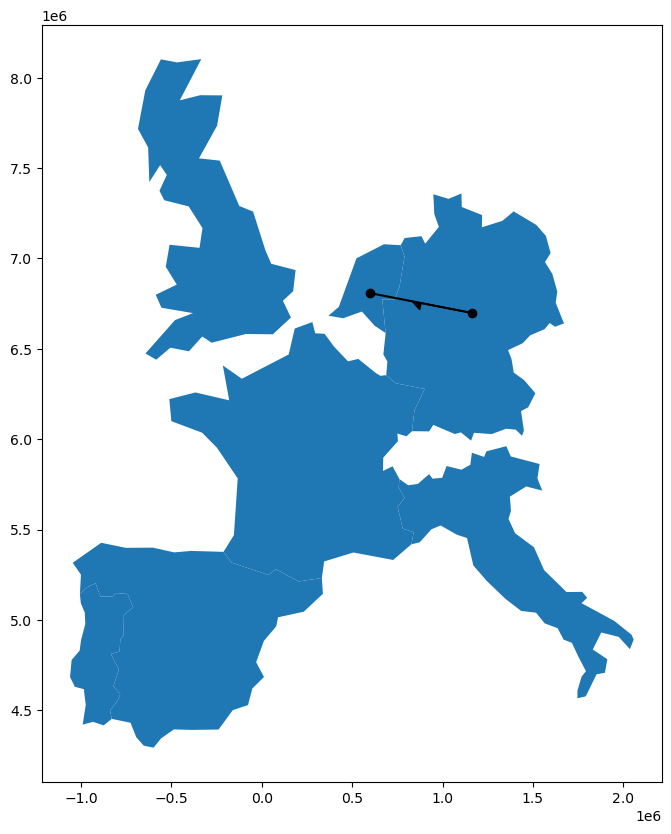

In [10]:
# Test from/to plot
x = grouped_df.loc[1, "league_from_point"][0].x
y = grouped_df.loc[1, "league_from_point"][0].y
x1 = grouped_df.loc[1, "league_to_point"][0].x
y1 = grouped_df.loc[1, "league_to_point"][0].y

f, ax = plt.subplots(figsize=(8,10))

ax.plot([x,x1],[y,y1],'ko-')
ax.arrow(
        x, y, (x1-x)/2, (y1-y)/2, 
        color="black",
        head_width=75000,
        head_length=50000,
        zorder=10,
        shape="right"
    )

for country in country_list:
    world_gdf[world_gdf["name"] == country].plot(ax=ax)

---

## Mapping & Graphing

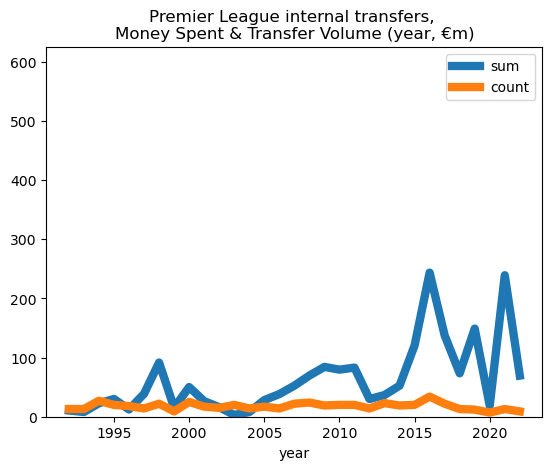

In [11]:
grouped_df_year[(grouped_df_year[("league_from_name",'')]=="Premier League") & (grouped_df_year[("league_to_name",'')]=="Premier League")][["year","fee_cleaned"]]\
.plot(x="year", y="fee_cleaned", lw=6)
plt.ylim((0,625))
plt.title("Premier League internal transfers, \nMoney Spent & Transfer Volume (year, €m)");

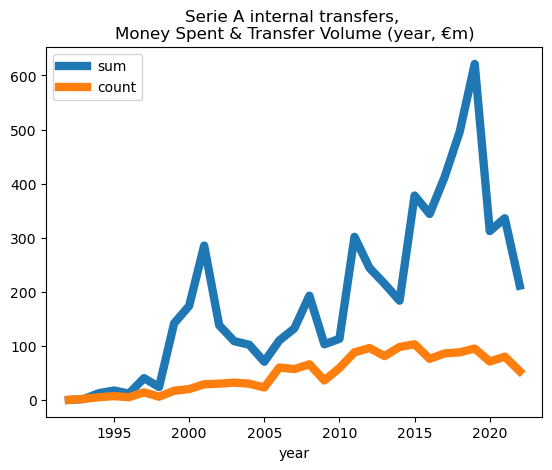

In [12]:
grouped_df_year[(grouped_df_year[("league_from_name",'')]=="Serie A") & (grouped_df_year[("league_to_name",'')]=="Serie A")][["year","fee_cleaned"]]\
.plot(x="year", y="fee_cleaned", lw=6)
plt.title("Serie A internal transfers, \nMoney Spent & Transfer Volume (year, €m)");

In [14]:
# Split transfers within leagues and between leagues
inside_transfers = grouped_df.loc[grouped_df[('league_from_name','')] == grouped_df[('league_to_name','')]]
outside_transfers = grouped_df.loc[grouped_df[('league_from_name','')] != grouped_df[('league_to_name','')]]

# Create normalised cmap from external transfers
cmap=plt.cm.Greens
norm = colors.Normalize(outside_transfers[('fee_cleaned', 'sum')].min(),outside_transfers[('fee_cleaned', 'sum')].max())
scalar = cmx.ScalarMappable(norm=norm, cmap=cmap)

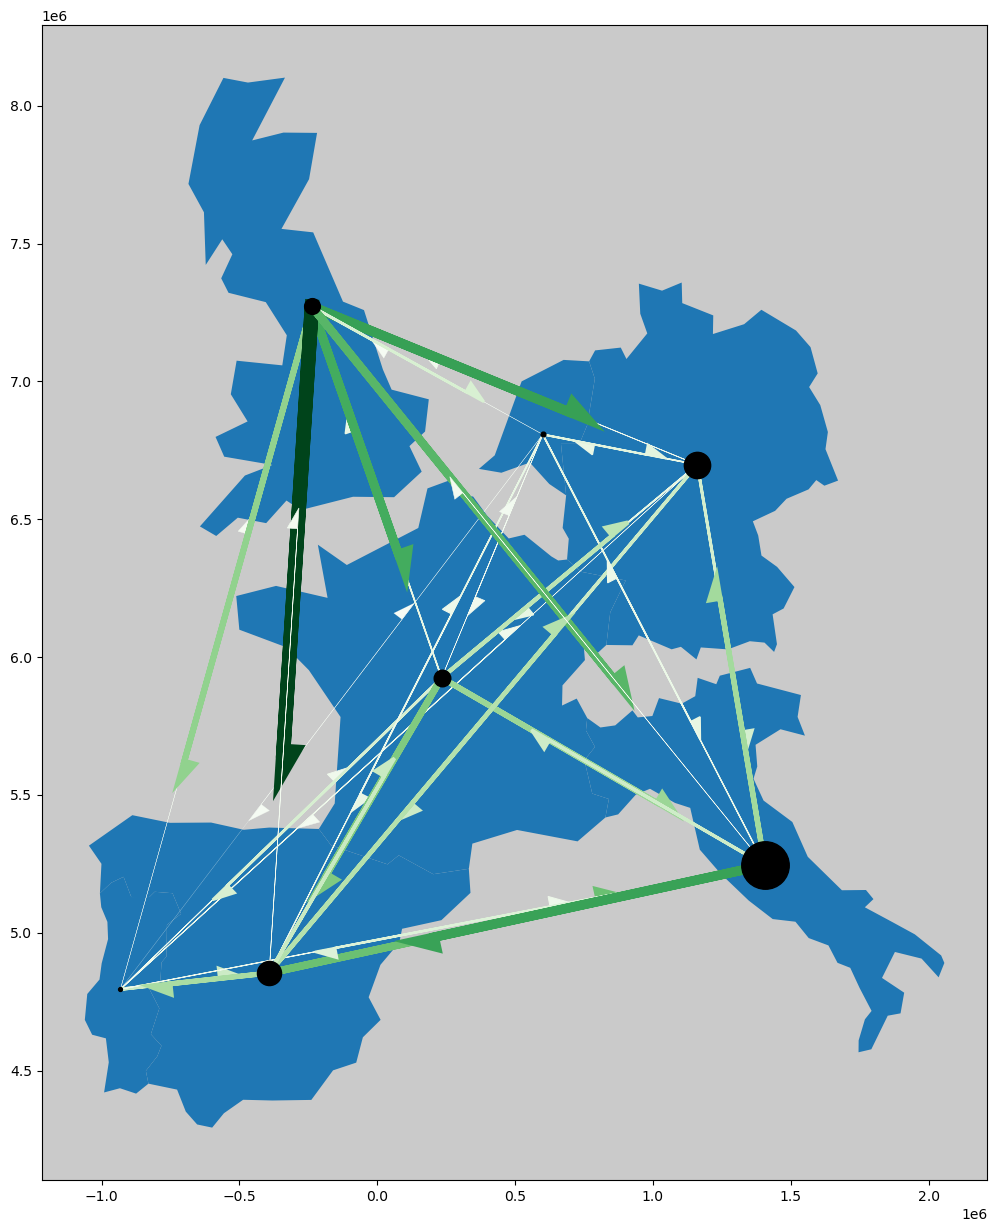

In [16]:
# Plot all data
f, ax = plt.subplots(figsize=(15,15))

# Plot internal transfers as points
for index, row in inside_transfers.iterrows():
    x1 = inside_transfers.loc[index, "league_from_point"][0].x
    y1 = inside_transfers.loc[index, "league_from_point"][0].y

    # plot point
    ax.plot(
        x1, y1,
        marker="o",
        markersize=row[('fee_cleaned', 'sum')]/inside_transfers[('fee_cleaned', 'sum')].sum() * 100,
        c="black",
        zorder=25
    )

# Plot flows
for index, row in outside_transfers.iterrows():
    x1 = outside_transfers.loc[index, "league_from_point"][0].x
    x2 = outside_transfers.loc[index, "league_to_point"][0].x 
    y1 = outside_transfers.loc[index, "league_from_point"][0].y
    y2 = outside_transfers.loc[index, "league_to_point"][0].y 
    
    # ax.plot(
    #     [x1, x2], [y1, y2], 'ko-',
    #     linewidth=row[('fee_cleaned', 'count')]/50, 
    #     alpha=0.25
    # )

    colourmapped = scalar.to_rgba(row[('fee_cleaned', 'sum')])

    ax.arrow(
            x1, y1, (x2-x1)/1.5, (y2-y1)/1.5, 
            # color=row[('fee_cleaned', 'count')],
            color=colourmapped,
            linewidth=row[('fee_cleaned', 'sum')]/outside_transfers[('fee_cleaned', 'sum')].sum()*100,
            length_includes_head=False,
            head_width=75000,
            head_length=75000,
            zorder=10,
            shape="right"
        )
for country in country_list:
    world_gdf[world_gdf["name"] == country].plot(ax=ax)

ax.set_facecolor('#cacaca')